In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def calc_unc(values):
    return (max(values) - min(values)) / 2

In [4]:
diesel_df = pd.read_csv('diesel_data.csv')
petrol_df = pd.read_csv('petrol_data.csv')

In [5]:
diesel = {'fuel': 'diesel', 'Vd': 1.9, 'rv': 22, 'CV': 42500, 'rho': 840, 'clfm': 55.9 * 10 ** (-6)}
petrol = {'fuel': 'petrol', 'Vd': 1.198, 'rv': 10.3, 'CV': 44000, 'rho': 770, 'clfm': 50.199 * 10 ** (-6)}

arho = 1.2

gamma = 1.4

In [6]:
def remove_columns(df):
    return df[[ 'Air Flow Pressure (Pa)', 'Torque (Nm)', 'Engine Speed (rpm)', 'Fuel Flow Rate (cm^3/min)', 'Exhaust Temp. (C)', 'Plant In Temp. (C)']]

In [7]:
diesel_df = remove_columns(diesel_df)
petrol_df = remove_columns(petrol_df)

In [8]:
def addCalculatedColumns(df, dict):
    df['Brake Power [kW]'] = df['Torque (Nm)'] * df['Engine Speed (rpm)'] * 2 * np.pi / 60 * 10 ** (-3)
    df['BMEP [kPa]'] = df['Torque (Nm)'] * 4 * np.pi / dict['Vd']
    df['Air Mass Flow Rate [kg/s]'] = dict['clfm']  * arho * df['Air Flow Pressure (Pa)']
    df['Fuel Mass Flow Rate [kg/s]'] = df['Fuel Flow Rate (cm^3/min)'] * 60 / 10 ** 6 * dict['rho']
    df['Cut-off Ratio'] = ((df['Exhaust Temp. (C)'] + 273) / (df['Plant In Temp. (C)'] + 273)) ** (1 / gamma)
    df['Air to Fuel Ratio'] = df['Air Mass Flow Rate [kg/s]'] / df['Fuel Mass Flow Rate [kg/s]']
    df['Brake Thermal Efficiency'] = (df['Brake Power [kW]'] * 10 ** 3)/ (df['Fuel Mass Flow Rate [kg/s]'] * dict['CV'])
    df['Volumetric Efficiency'] = (df['Fuel Mass Flow Rate [kg/s]'] * 10 ** 3) / (dict['Vd'] * arho)
    df['Brake Specific Fuel Consumption'] = df['Fuel Mass Flow Rate [kg/s]'] / df['Brake Power [kW]'] * 60 * 10 ** (-3)

    if dict['fuel'] == 'petrol':
        df['Thermal Efficiency'] = 1 - 1 / (dict['rv'] ** (gamma - 1))

    if dict['fuel'] == 'diesel':
        df['Thermal Efficiency'] = 1 - 1 / gamma * 1 / (dict['rv'] ** (gamma - 1)) * (df['Cut-off Ratio'] ** gamma - 1) / (df['Cut-off Ratio'] - 1)
    
    return df

In [9]:
diesel_df = addCalculatedColumns(diesel_df, diesel)
petrol_df = addCalculatedColumns(petrol_df, petrol)

In [10]:
def scatter(axs, df, x, y, row, col):
    r = np.corrcoef(df[x], df[y])[0,1]
    axs[row, col].scatter(df[x], df[y])
    axs[row,col].set(xlabel=x, ylabel=y)
    axs[row, col].text(0.5, 0.9, f'Corr. coeff., r = {np.round(r, 2)}', horizontalalignment='center', verticalalignment='center', transform=axs[row, col].transAxes)

In [11]:
labels = ['Brake Power [kW]', 'Air Mass Flow Rate [kg/s]',
       'Fuel Mass Flow Rate [kg/s]', 'Air to Fuel Ratio',
       'Brake Thermal Efficiency', 'Volumetric Efficiency',
       'Brake Specific Fuel Consumption', 'Cut-off Ratio', 'Thermal Efficiency']

In [12]:
def plot(df):
    row = 0
    col = 0
    f, axs = plt.subplots(3,3,figsize=(12,8))
    f.tight_layout(pad=3)
    for label_index in range(len(labels)):
        scatter(axs, df, 'Engine Speed (rpm)', labels[label_index], row, col)
        if (label_index+1) % 3 == 0:
                col = 0
                row += 1
        else:
                col += 1
    plt.show()

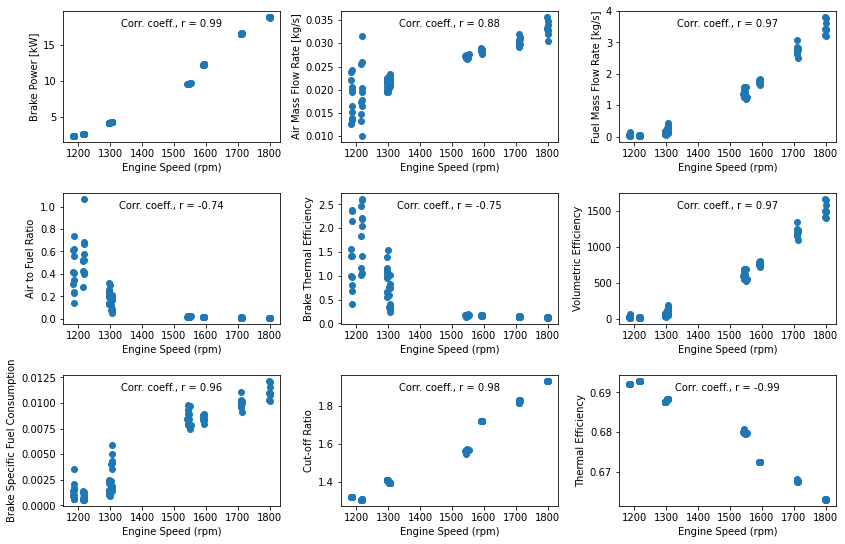

In [31]:
plot(diesel_df)

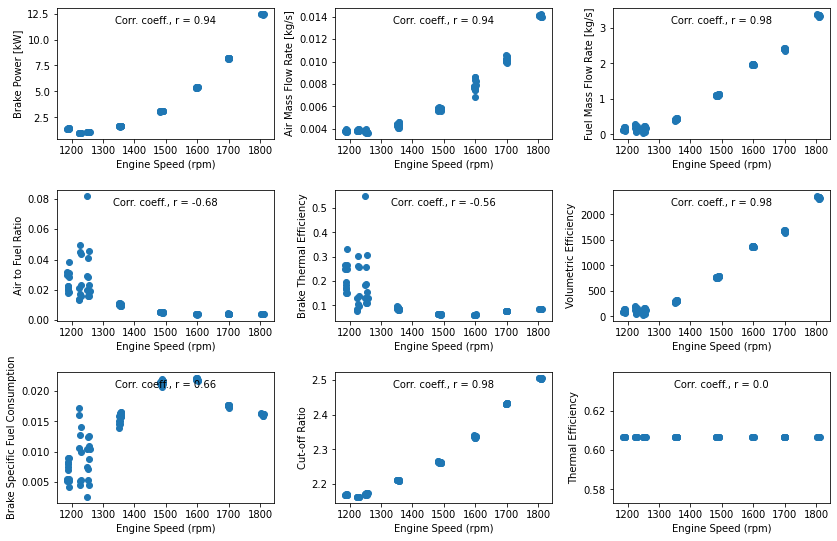

In [32]:
plot(petrol_df)

In [33]:
speed_operating_point_ranges = [(1150, 1280), (1280, 1400), (1450, 1580), (1580, 1620), (1680, 1730), (1780, 1820)]

In [13]:
def mask(range, df):
    return (df['Engine Speed (rpm)'] > range[0]) & (df['Engine Speed (rpm)'] < range[1])

In [14]:
def get_df_from_list_of_series(list):
    dict = {label: [] for label in list[0].index}

    for series in list:
        for label in series.index:
            dict[label].append(series[label])

    return pd.DataFrame.from_dict(dict)

In [15]:
def get_average_and_range_dfs_as_dict(df):

    averages = []
    descriptions = []

    for range_value in speed_operating_point_ranges:
        averages.append(df[mask(range_value, df)].mean())
        descriptions.append(df[mask(range_value, df)].describe())

    ranges = []

    for description in descriptions:
        description = description.transpose()
        description['range'] = description['std'] * 3
        ranges.append(description['range'])

    return {'average': get_df_from_list_of_series(averages), 'range': get_df_from_list_of_series(ranges)}


In [16]:
petrol_dict = get_average_and_range_dfs_as_dict(petrol_df)
diesel_dict = get_average_and_range_dfs_as_dict(diesel_df)

In [21]:
quantity_error_dict = {'Brake Power [kW]': ['Torque (Nm)', 'Engine Speed (rpm)'], 'Brake Thermal Efficiency': ['Torque (Nm)', 'Engine Speed (rpm)', 'Fuel Flow Rate (cm^3/min)'], 'Brake Specific Fuel Consumption': ['Torque (Nm)', 'Engine Speed (rpm)', 'Fuel Flow Rate (cm^3/min)'], 'BMEP [kPa]': ['Torque (Nm)'], 'Volumetric Efficiency': ['Engine Speed (rpm)', 'Air Flow Pressure (Pa)'], 'Air to Fuel Ratio': ['Air Flow Pressure (Pa)', 'Fuel Flow Rate (cm^3/min)'], 'Cut-off Ratio': ['Plant In Temp. (C)', 'Exhaust Temp. (C)']}

In [22]:
def get_y_error_list(x, y, fuel_df_dict, quantity_of_interest):
    df_average = fuel_df_dict['average'] 
    df_range = fuel_df_dict['range']

    y_error_list = [0 for i in range(len(x))]

    for quantity in quantity_error_dict[quantity_of_interest]:
        for i in range(len(x)):
            y_error_list[i] += df_range[quantity][i] / df_average[quantity][i]
    if quantity_of_interest == 'Cut-off Ratio':
        return [y_error_list[i] * y[i] * 1 / gamma for i in range(len(y))]
    else:
        return [y_error_list[i] * y[i] for i in range(len(y))]

In [23]:
def get_fuel_axis(fuel_dict, quantity_of_interest):
    df_average_petrol = petrol_dict['average']
    x_fuel = df_average_petrol['Engine Speed (rpm)'].tolist()
    y_fuel = df_average_petrol[quantity_of_interest].tolist()
    y_err = get_y_error_list(x_fuel, y_fuel, fuel_dict, quantity_of_interest)

    return x_fuel, y_fuel, y_err

In [28]:
def plot_individual_quantity(quantity_of_interest):
    if quantity_of_interest == 'Cut-off Ratio':
        fig, axs = plt.subplots()
        x_diesel, y_diesel, y_err_diesel = get_fuel_axis(diesel_dict, quantity_of_interest)
        axs.errorbar(x_diesel, y_diesel , yerr=y_err_diesel, fmt='o')

    else:
        fig, axs = plt.subplots(1, 2)

        x_petrol, y_petrol, y_err_petrol = get_fuel_axis(petrol_dict, quantity_of_interest)
        x_diesel, y_diesel, y_err_diesel = get_fuel_axis(diesel_dict, quantity_of_interest)

        axs[0].errorbar(x_petrol, y_petrol , yerr=y_err_petrol, fmt='o')
        axs[1].errorbar(x_diesel, y_diesel , yerr=y_err_diesel, fmt='o')

Brake Power [kW]
Brake Thermal Efficiency
Brake Specific Fuel Consumption
BMEP [kPa]
Volumetric Efficiency
Air to Fuel Ratio
Cut-off Ratio


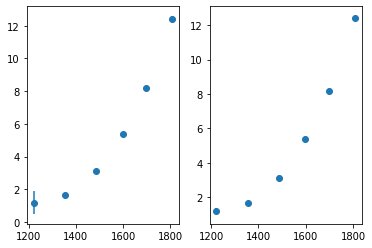

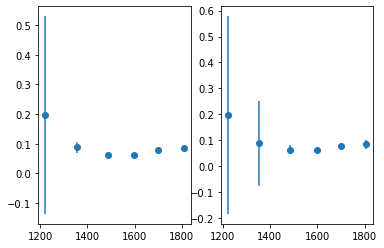

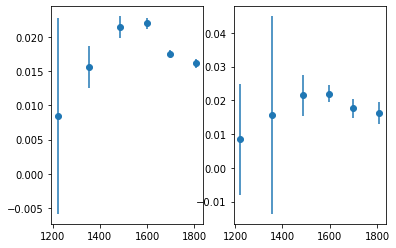

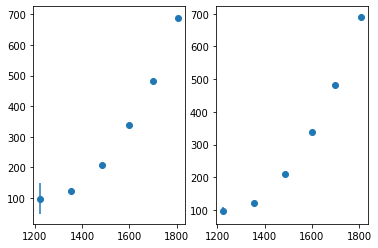

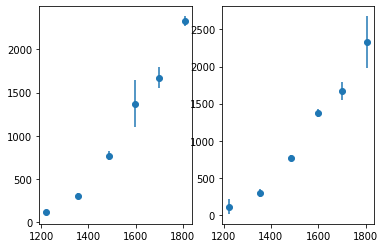

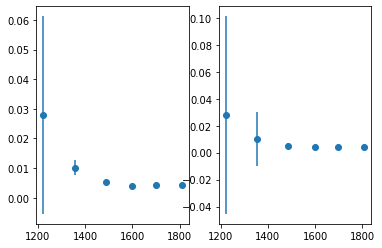

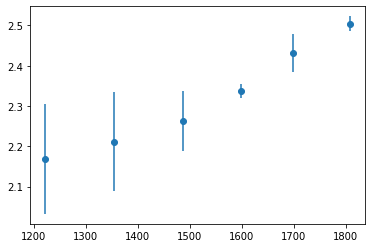

In [30]:
for key in quantity_error_dict:
    plot_individual_quantity(key)